In [126]:
import tensorflow as tf
from tensorflow.keras import layers, models

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [127]:
# Define constants
BATCH_SIZE = 32
IMAGE_SIZE = 120
CHANNELS = 3 # (RGB)
n_classes = 2 # This implies binary classification
EPOCHS = 10 # 10 full passes over the training data set

In [130]:
# Input shape
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [131]:
# Define the model (assuming your previous model definition for binary classification)
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'), # Output layer for 2 classes (binary)
])

In [132]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 118, 118, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 57, 57, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 26, 26, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 11, 11, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 195,777 (764.75 KB)

 Trainable params: 195,777 (764.75 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
# --- Data Loading and Preprocessing ---

# This creates datasets where EACH ELEMENT IS ALREADY A BATCH
# The `batch_size=BATCH_SIZE` here is correct and sufficient.
dataset = tf.keras.utils.image_dataset_from_directory(
    "concrete_surface",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, # This creates batches with shape (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    labels='inferred', # Assumes subdirectories define classes
    label_mode='binary' # Important for 2 classes, yields integer labels (0 or 1)
)


Found 40000 files belonging to 2 classes.


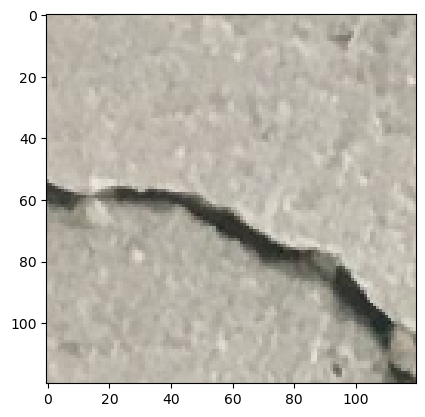

In [134]:
for image_batch, label_batch in train_ds.take(1):
    plt.imshow(image_batch[0].numpy())

In [135]:
# ---Limit the dataset to approximately 6000 files (188 batches) ---
dataset = dataset.take(188) # Takes the first 188 batches

# Determine the size of the dataset in terms of batches
ds_size = tf.data.experimental.cardinality(dataset).numpy()

# It's better to use an actual dataset size for splitting
# Instead of hardcoding 54 and 6, calculate based on ds_size
train_split_ratio = 0.8
val_split_ratio = 0.1
test_split_ratio = 0.1 # This will be the remainder

train_size = int(train_split_ratio * ds_size)
val_size = int(val_split_ratio * ds_size)

train_ds = dataset.take(train_size)
temp_ds = dataset.skip(train_size)
val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)


In [136]:
len(train_ds)

150

In [137]:
# Define preprocessing function
def preprocess_image(image, label):
    # Resize and cast to float32 are already handled by image_dataset_from_directory
    # when you specify image_size. Normalization is usually the main step here.
    image = tf.cast(image, tf.float32) / 255.0 # Normalize pixel values to [0, 1]
    return image, label

In [138]:
# Map preprocessing function to datasets.
# Crucially, DO NOT add .batch(BATCH_SIZE) again here!
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).prefetch(tf.data.AUTOTUNE) # No .batch() here

val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE) # No .batch() here

test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE) # No .batch() here

In [139]:
# --- Model Compilation ---
model.compile(
    optimizer = 'adam',
    # Use BinaryCrossentropy for a sigmoid output layer with 2 classes (labels 0 or 1)
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [140]:
# --- Model Training ---
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    # REMOVE batch_size = BATCH_SIZE, because train_ds is ALREADY batched
    verbose = 1,
    validation_data = val_ds
)


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 80s 467ms/step - accuracy: 0.7494 - loss: 0.4306 - val_accuracy: 0.9375 - val_loss: 0.1794
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 71s 439ms/step - accuracy: 0.9776 - loss: 0.0754 - val_accuracy: 0.9809 - val_loss: 0.0603
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 423ms/step - accuracy: 0.9819 - loss: 0.0593 - val_accuracy: 0.9826 - val_loss: 0.0636
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 417ms/step - accuracy: 0.9744 - loss: 0.0755 - val_accuracy: 0.9705 - val_loss: 0.0647
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 408ms/step - accuracy: 0.9773 - loss: 0.0675 - val_accuracy: 0.9757 - val_loss: 0.0630
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 408ms/step - accuracy: 0.9840 - loss: 0.0433 - val_accuracy: 0.9861 - val_loss: 0.0482
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 407ms/step - accuracy: 0.9842 - loss: 0.0451 - val_accuracy: 0.9844 - val_loss: 0.0557
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 406ms/step - accuracy: 0.9902 - loss: 0

In [63]:
# model.summary() # Print summary to see the layers and parameter count

In [141]:
scores = model.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9605 - loss: 0.1538


In [162]:
model.save('concrete_surface_model.h5')

In [142]:
len(history.history['accuracy'])

10

In [143]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [166]:
val_loss

[0.17940753698349,
 0.060332801192998886,
 0.06358304619789124,
 0.06470923125743866,
 0.06299105286598206,
 0.04815433919429779,
 0.05570437014102936,
 0.05812826380133629,
 0.09156458079814911,
 0.1909899115562439]

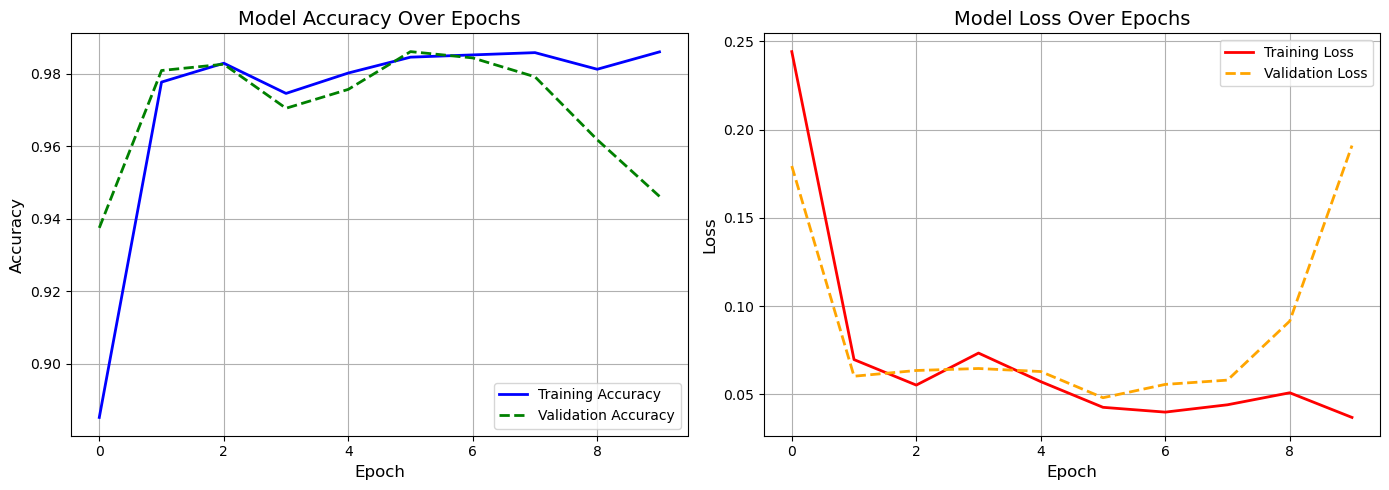

In [144]:
import matplotlib.pyplot as plt

# ✅ Plot Accuracy and Loss in a professional way
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # ✅ Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='green', linestyle='--', linewidth=2)
    plt.title('Model Accuracy Over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True)

    # ✅ Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='red', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', linestyle='--', linewidth=2)
    plt.title('Model Loss Over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ✅ Call the function after training
plot_training_history(history)


First image to Predict


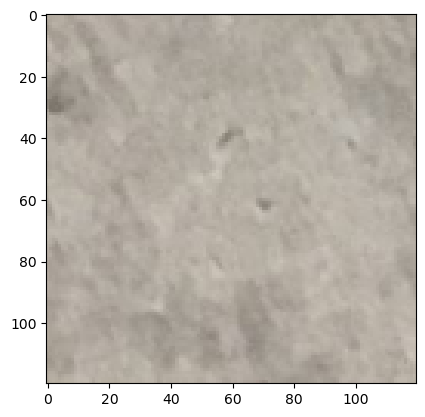

In [145]:
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    # first_label = labels_batch[0].numpy()

    print("First image to Predict")
    plt.imshow(first_image)

C:\Users\Admin\AppData\Local\Temp\ipykernel_1728\3548403645.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  first_label = int(labels_batch[0].numpy())


First image to Predict
Actual Label:  Defect
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Predicted Label:  Defect
(Raw probability: 1.0000)


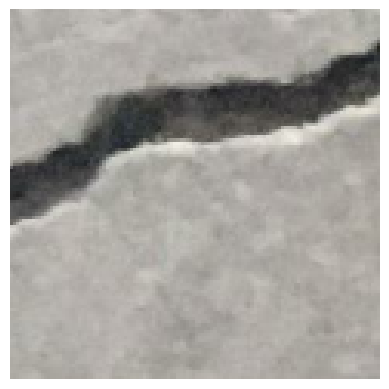

In [157]:
for images_batch, labels_batch in test_ds.take(1):
    # first_image = images_batch[0].numpy().astype('uint8')
    first_label = int(labels_batch[0].numpy())
    first_image_float = images_batch[0].numpy() # Keep it as float here to inspect
    print("First image to Predict")
    plt.imshow(first_image_float)
    plt.axis("off")
    print("Actual Label: ", class_names[first_label])

    batch_prediction = model.predict(images_batch)

    # Get the prediction for the first image in the batch
    prediction_prob = batch_prediction[0][0] # Access the scalar probability

    # Convert probability to class index using a threshold (e.g., 0.5)
    predicted_class_index = 1 if prediction_prob >= 0.5 else 0

    print("Predicted Label: ", class_names[predicted_class_index])
    print(f"(Raw probability: {prediction_prob:.4f})") # Optional: show raw probability

# plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


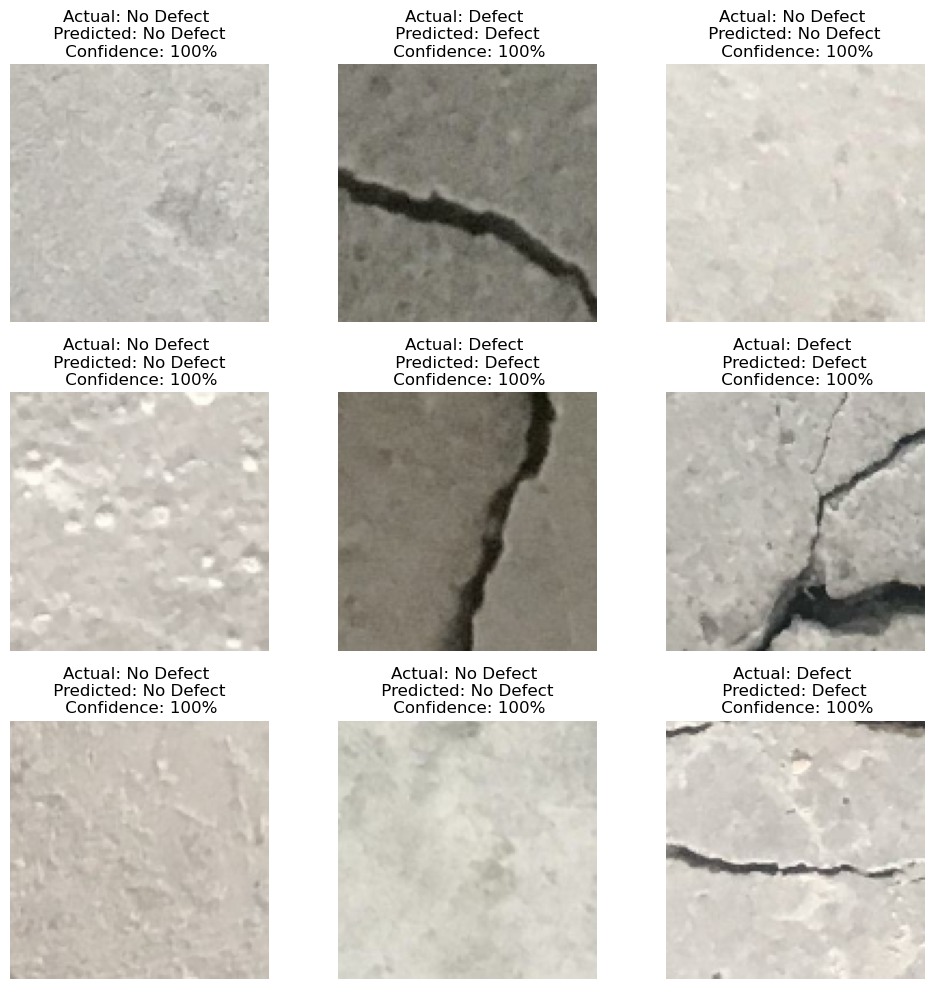

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def display_nine_predictions_from_batch(model, test_ds, class_names):
    """
    Displays a 3x3 grid of images from a test batch with their actual and predicted labels.

    Args:
        model: The trained Keras model.
        test_ds: The TensorFlow test dataset.
        class_names: A list of class names (e.g., ["No Defect", "Defect"]).
    """
    plt.figure(figsize=(10, 10)) # Set a larger figure size for the grid

    for images_batch, labels_batch in test_ds.take(1): # Take just one batch
        # Perform prediction on the ENTIRE batch once
        batch_predictions = model.predict(images_batch)

        # Iterate through the first 9 images (or fewer if the batch size is smaller)
        for i in range(min(9, images_batch.shape[0])):
            ax = plt.subplot(3, 3, i + 1)

            # Display the image
            plt.imshow(images_batch[i].numpy())

            # Get the prediction for the current image from the batch_predictions
            prediction_prob = batch_predictions[i][0] # Access the scalar probability for class 1

            # Determine the predicted class based on a 0.5 threshold
            predicted_class_index = 1 if prediction_prob >= 0.5 else 0
            predicted_class = class_names[predicted_class_index]

            # Get the actual class label, ensuring it's a Python integer for indexing
            actual_class = class_names[int(labels_batch[i].numpy().item())]

            # Calculate confidence for the predicted class
            if predicted_class_index == 1:
                confidence = prediction_prob
            else: # predicted_class_index == 0
                confidence = 1 - prediction_prob
            confidence = round(100 * confidence)

            # Set the title with actual, predicted, and confidence
            plt.title(f'Actual: {actual_class} \n Predicted: {predicted_class} \n Confidence: {confidence}%')

            plt.axis("off")

    plt.tight_layout() # Adjust subplot params for a tight layout
    plt.show() # Display the entire grid of plots

display_nine_predictions_from_batch(model, test_ds, class_names)